# VL frontend

Enter the SMILES of a compound in the SLAP virtual library and see the predicted properties + synthesizability.

In [1]:
# input (change this to the SMILES you are interested in)
# do not include stereochemistry descriptors on the central heterocycle

query = "Cc1cnn(C)c1C1COC(C)C(c2ccc3cc(F)c(F)cc3n2)N1"


In [2]:
import IPython.display
import pathlib
import pandas as pd
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions

from src.util.rdkit_util import remove_mapno_from_reaction, canonicalize_smiles

In [3]:
# import all smiles in the VL
vl_dir = pathlib.Path("../data/VL/")
dfs = []
for i in range(1749):
    dfs.append(pd.read_csv(vl_dir / f"VL_chunk_{i:04}_smiles.csv.bz2"))
df_allsmiles = pd.concat(dfs)

In [4]:
# check if the queried smiles is in the VL
canonical_query = canonicalize_smiles(query)
try:
    mol_number = int(df_allsmiles.loc[df_allsmiles["smiles"] == canonical_query, "mol_number"])
except TypeError:
    print("The input SMILES was not found in the virtual library")

In [5]:
# determine which chunk the data we are looking for is in
chunk = mol_number // 10000

In [6]:
# read only the file for the relevant chunk
df_props = pd.read_csv(vl_dir / f"VL_chunk_{chunk:04}.csv.bz2")

In [7]:
# extract the queried compound
df_compound = df_props.loc[df_props["mol_number"] == mol_number]

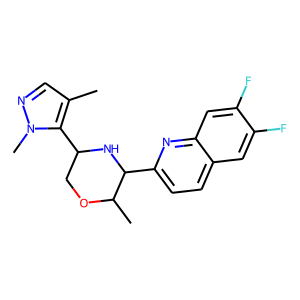

In [8]:
# draw the structure for control
mol = Chem.MolFromSmiles(df_compound.at[0,"smiles"])
Draw.MolToImage(mol)

In [9]:
# Print the predicted properties
print(f"Predicted properties for {query}:")
print(f"Predicted logD at pH 7.4: {df_compound.at[0,'predicted_logD_pH7.4']:.1f}")
print(f"Predicted aq solubility at pH 6.8: {10 ** df_compound.at[0,'predicted_logSolubility_pH6.8_(mM)']:.3f} mM")
print(f"Predicted pKa: {df_compound.at[0,'center1_pKa']:.1f}")

Predicted properties for Cc1cnn(C)c1C1COC(C)C(c2ccc3cc(F)c(F)cc3n2)N1:
Predicted logD at pH 7.4: 3.4
Predicted aq solubility at pH 6.8: 0.093 mM
Predicted pKa: 5.7


In [10]:
# Show full pKa information (there may be multiple ionizable centers)
print(df_compound[[s for s in df_compound.columns if s.startswith("center")]].dropna(axis=1).iloc[0])

center1_acidorbase               b
center1_pKa                   5.72
center1_atom_number           26.0
center1_prediction_quality    0.62
center2_acidorbase               b
center2_pKa                    3.1
center2_atom_number           25.0
center2_prediction_quality    0.69
center3_acidorbase               b
center3_pKa                   0.66
center3_atom_number            4.0
center3_prediction_quality    0.59
Name: 0, dtype: object


Reactions leading to this compound:

C[Si](C)(C)[CH2:8][O:7][CH:6]([CH:4]([c:3]1[cH:15][cH:17][c:19]2[c:18]([n:16]1)[cH:20][c:22]([F:24])[c:23]([F:25])[cH:21]2)[NH2:5])[CH3:26].O=[CH:2][c:1]1[n:9]([CH3:12])[n:11][cH:14][c:10]1[CH3:13]>>[c:1]1([CH:2]2[NH:5][CH:4]([c:3]3[cH:15][cH:17][c:19]4[c:18]([n:16]3)[cH:20][c:22]([F:24])[c:23]([F:25])[cH:21]4)[CH:6]([CH3:26])[O:7][CH2:8]2)[n:9]([CH3:12])[n:11][cH:14][c:10]1[CH3:13]


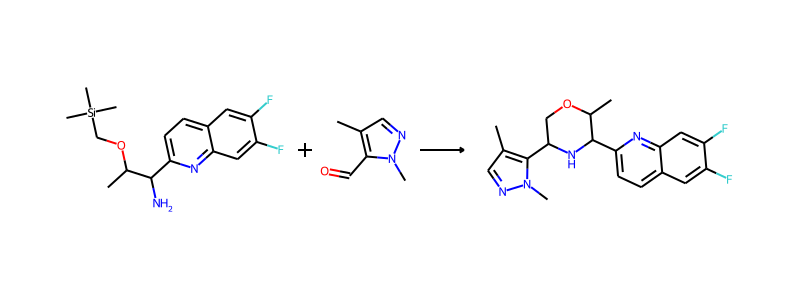

Predicted outcome: 0 (failure)
Prediction confidence: 3 (moderate)


In [11]:
outcomes = {0: "failure", 1: "success"}
confidences = {0: "known reaction", 1: "very high", 2: "high", 3: "moderate", 4: "low"}

print("Reactions leading to this compound:\n")
# todo draw the reaction
for i, rxn_smiles in enumerate([df_compound.at[0,'rxn1_smiles'], df_compound.at[0,'rxn2_smiles']]):
    if isinstance(rxn_smiles, str):
        reaction_outcome = int(df_compound.at[0, f'rxn{i+1}_predictions'])
        prediction_confidence = int(df_compound.at[0, f'rxn{i+1}_confidence'])
        print(rxn_smiles)
        rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)
        remove_mapno_from_reaction(rxn)
        d2d = Draw.MolDraw2DCairo(800,300)
        d2d.DrawReaction(rxn)
        d2d.FinishDrawing()
        p = d2d.GetDrawingText()
        i = IPython.display.Image(p)
        display(i)
        print(f"Predicted outcome: {reaction_outcome} ({outcomes[reaction_outcome]})")
        print(f"Prediction confidence: {prediction_confidence} ({confidences[prediction_confidence]})")